## Hamiltonian MCMC baseline performance - 2D Gaussian

The purpose of this notebook is to propose baseline settings --- sampler hyperparameters and number of MCMC iterations --- for the Hamiltonian MCMC sampler on a 2D Gaussian distribution.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pints
import pints.toy
import pints.plot

# Define pdf 
# (prior is only used to sample starting positions for chains)
normal_log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=100),
    pints.GaussianLogPrior(mean=0, sd=100))

# Set up hyperparameters
initial_parameters = log_prior.sample(n=10)
n_chains = 10

method = pints.HamiltonianMCMC
is_run_parallel = True

In [2]:
# Make a small grid of HMC hyperparameters
leapfrog_steps = [5, 10, 20]
leapfrog_step_sizes = [0.02, 0.5, 2.0]

warmup = 200
n_iterations = 400

for step in leapfrog_steps:
    for size in leapfrog_step_sizes:
        # Set up problem
        sampler = pints.MCMCController(
            log_pdf=normal_log_pdf,
            x0=initial_parameters,
            chains=n_chains,
            method=method)
        sampler.set_max_iterations(n_iterations)
        sampler.set_parallel(is_run_parallel)
        sampler.set_log_to_screen(False)

        for s in sampler.samplers():
            s.set_leapfrog_step_size(size)
            s.set_leapfrog_steps(step)

        # Sample
        chains = sampler.run()
        
        print('Leapfrog: {}, step size: {}, time: {:.2f}s'.format(step, size, sampler.time()))
        print(pints.MCMCSummary(chains=chains[:, warmup:]))
        print('\n\n')

Leapfrog: 5, step size: 0.02, time: 7.07s
param    mean    std.    2.5%     25%      50%     75%    97.5%    rhat    ess
-------  ------  ------  -------  -------  ------  -----  -------  ------  -----
param 1  14.57   87.34   -104.12  -38.08   -7.56   71.37  185.90   603.36  31.46
param 2  -28.80  87.50   -147.46  -102.87  -31.18  12.44  142.22   668.71  33.57



Leapfrog: 5, step size: 0.5, time: 7.91s
param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----
param 1  -0.12   0.97    -2.11   -0.71  -0.21  0.44   2.11     1.40    81.17
param 2  -0.10   0.91    -1.84   -0.73  -0.11  0.48   1.70     1.12    70.48



Leapfrog: 5, step size: 2.0, time: 6.58s
param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------
param 1  -0.04   0.99    -2.00   -0.65  -0.05  0.61   1.88     1.00    414.39
param 2  0.

These results suggest that strong performance can be achieved using 10 leapfrog steps with a step size of 2. While 20 leapfrog steps may be slightly better, it takes much longer to run.

Now we run a longer chain with these settings.

In [3]:
n_iterations = 10000
warmup = 1000

sampler = pints.MCMCController(
    log_pdf=normal_log_pdf,
    x0=initial_parameters,
    chains=n_chains,
    method=method)
sampler.set_max_iterations(n_iterations)
sampler.set_parallel(is_run_parallel)
sampler.set_log_to_screen(False)

for s in sampler.samplers():
    s.set_leapfrog_step_size(2.0)
    s.set_leapfrog_steps(10)

# Sample
chains = sampler.run()
print(pints.MCMCSummary(chains=chains[:, warmup:]))

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess
-------  ------  ------  ------  -----  -----  -----  -------  ------  --------
param 1  -0.00   1.00    -1.95   -0.68  -0.00  0.67   1.95     1.00    30000.00
param 2  0.00    1.00    -1.96   -0.68  -0.00  0.68   1.97     1.00    30000.00


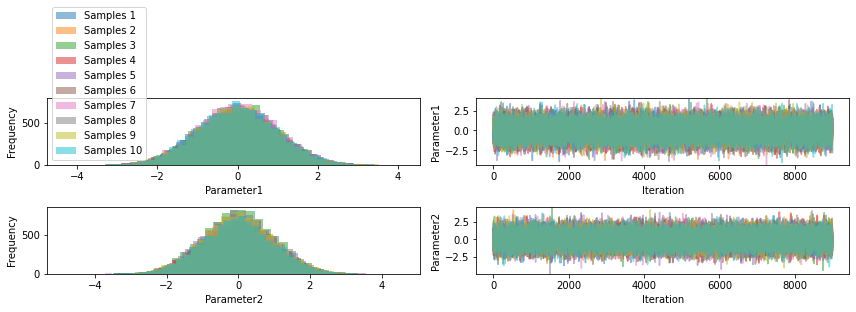

In [4]:
# Plot traces
fig = pints.plot.trace(chains[:,warmup:])
plt.show()

We can also plot the warmup phase.

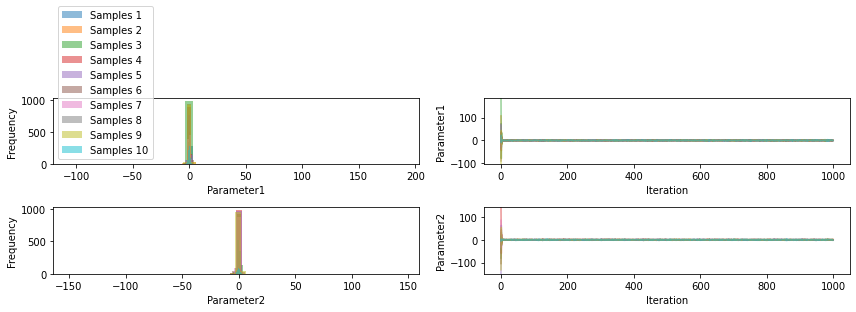

In [5]:
# Plot traces
fig = pints.plot.trace(chains[:,:warmup])
plt.show()

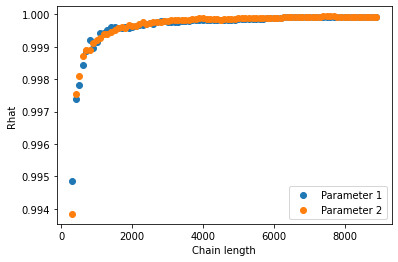

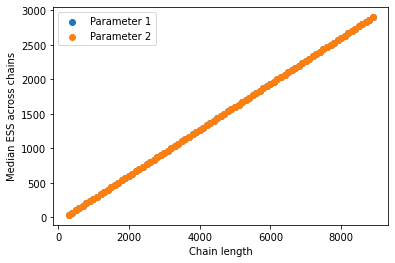

In [6]:
# Define chain lengths for Rhat evaluation
warmup = 200
chain_lengths = np.arange(start=300, stop=9000, step=100)

# Compute rhat
n_parameters = 2
n_lengths = len(chain_lengths)
rhats = np.empty(shape=(n_lengths, n_parameters))
ess = np.empty(shape=(n_chains, n_lengths, n_parameters))
for length_id, chain_length in enumerate(chain_lengths):
    # Get relevant chain samples
    cleaned_chains = chains[:, warmup:chain_length]

    # Compute rhat and ess
    rhats[length_id] = pints.rhat(cleaned_chains)
    for chain_id, chain in enumerate(cleaned_chains):
        ess[chain_id, length_id] = pints.effective_sample_size(chain)

# Plot evolution of rhat
plt.scatter(x=chain_lengths, y=rhats[:, 0], label='Parameter 1')
plt.scatter(x=chain_lengths, y=rhats[:, 1], label='Parameter 2')
plt.xlabel('Chain length')
plt.ylabel('Rhat')
plt.legend()
plt.show()

# Plot evolution of ess
median_ess = np.median(ess, axis=0)
plt.scatter(x=chain_lengths, y=median_ess[:, 0], label='Parameter 1')
plt.scatter(x=chain_lengths, y=median_ess[:, 1], label='Parameter 2')
plt.xlabel('Chain length')
plt.ylabel('Median ESS across chains')
plt.legend()
plt.show()

Convergence is near instant---the problem is extremely easy for HMC. The following baseline settings are suggested, which are more than sufficient to obtain a very accurate posterior when the sampler is working correctly.

Leapfrog steps: 10

Leapfrog step size: 2

Number of iterations: 2000 / 200 warmup

Number of chains: 3